In [16]:
import re
import cv2
import glob
import random as rd
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

warnings.filterwarnings("ignore")
%matplotlib inline


In [17]:
! pip install python-chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.8 MB/s eta 0:00:00a 0:00:01m


In [18]:
#Define train path and test path
train_path = glob.glob("../input/chess-positions/train/*.jpeg")
test_path = glob.glob("../input/chess-positions/test/*.jpeg")

#Shuffle train and test samples
rd.shuffle(train_path)
rd.shuffle(test_path)

#Decide the number of train and test samples
train_size =20000
test_size = 4000
train = train_path[:train_size]
test= test_path[:test_size]

# Piece_type = ['King','Queen','Rook','Bishop','Knight','Pawn']|
# Capital = White, Normal = Black
piece_symbols = 'prbnkqPRBNKQ'# Function to extract piece type and color from file path
def extract_piece_info(file_path):
    file_name = os.path.basename(file_path)
    color = "White" if "white" in file_name.lower() else "Black"
    piece_type = next((piece for piece in piece_symbols if piece in file_name), None)
    return color, piece_type

# Function to load and display an image
def load_and_display_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)  # Read image in color mode
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [19]:
# Get the labels ( FNE ) for the training and testing images 
def get_image_FEN_label(image_path):
    fen_label= image_path.replace('.jpeg', '').split('/')[-1]
    return fen_label

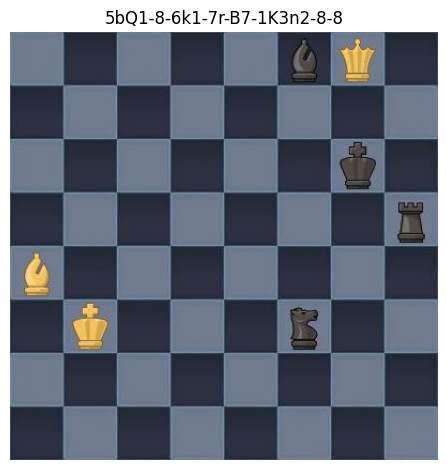

In [20]:
rand = np.random.randint(0, train_size)
img_path =train[rand]
img_moves =  get_image_FEN_label(img_path)
img_rand=cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_rand, cv2.COLOR_BGR2RGB))
plt.title(img_moves)
plt.axis('off')
plt.tight_layout()
plt.show()

The FEN notation of the image is:  5bQ1-8-6k1-7r-B7-1K3n2-8-8


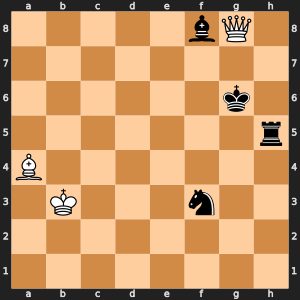

In [21]:
import chess.svg
import chess
print("The FEN notation of the image is: ", img_moves)
board = chess.Board(img_moves.replace('-', '/'))
chess.svg.board(board, size=300)

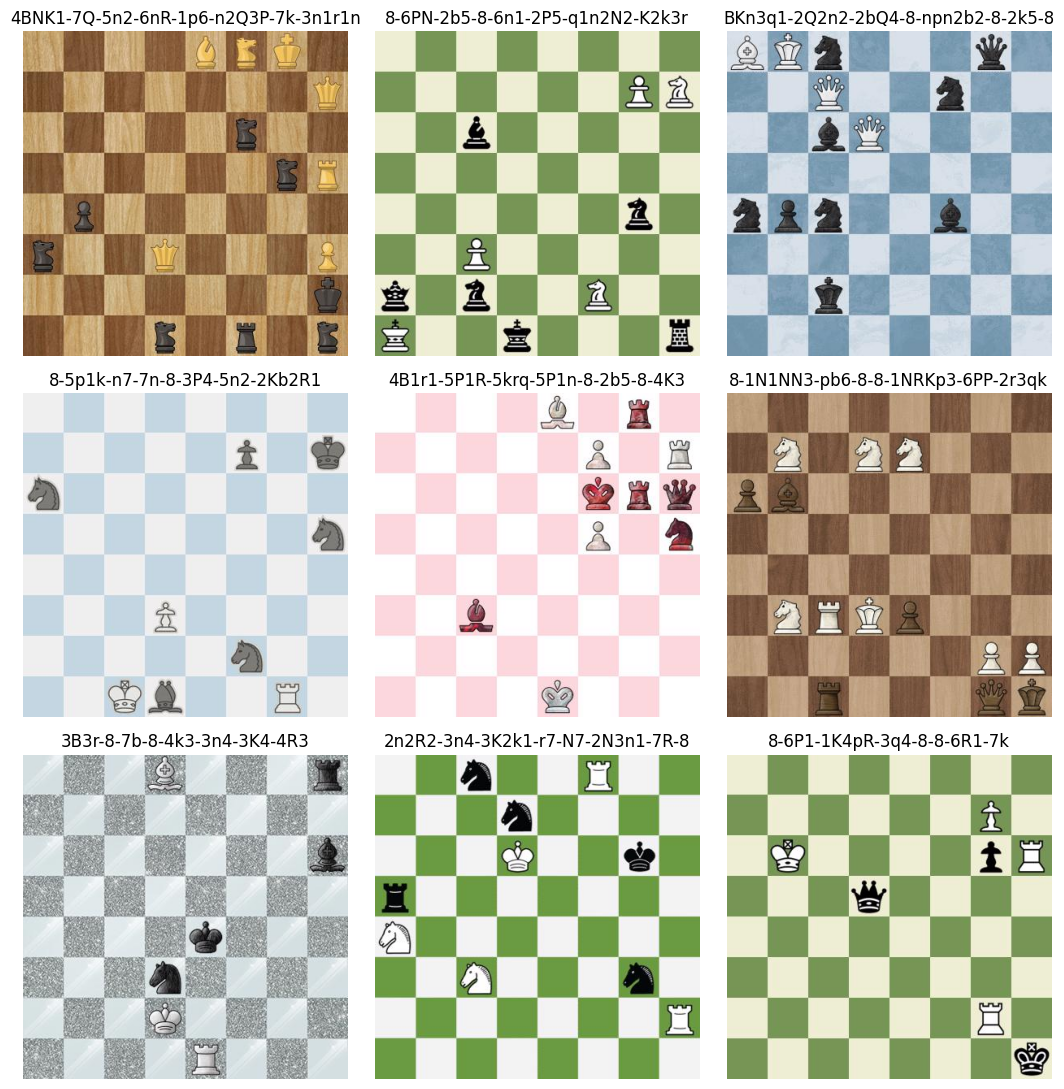

In [22]:
samples =rd.sample(train, 9)
fig = plt.figure(figsize=(11, 11))
columns = 3
rows = 3
for i, img in zip(range(1, columns*rows +1),samples ):
    fig.add_subplot(rows, columns, i)
    img_moves =  get_image_FEN_label(img)
    img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(img_moves)
    plt.tight_layout()
    
plt.show()

In [23]:
labels = [get_image_FEN_label(img) for img in train]
set_labels = set(labels)
print("Number of labels {} is equal to number of images {}".format(len(set_labels), len(train)))

Number of labels 20000 is equal to number of images 20000


Selected Width X heights: 400X400


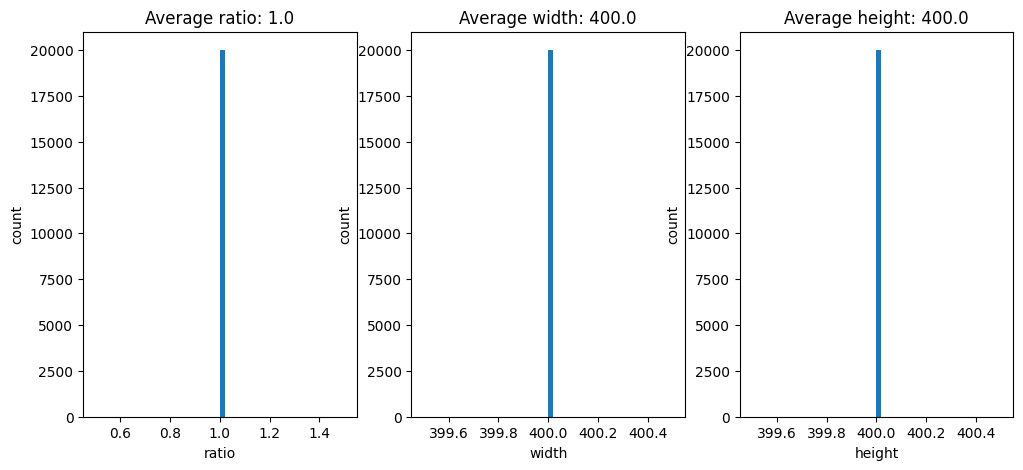

In [24]:
ratios = []
widths = []
heights = []

for img in train:
  img= cv2.imread(img)
  ratios.append(img.shape[1] / img.shape[0])  
  heights.append(img.shape[0])
  widths.append(img.shape[1])

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.hist(ratios, bins=50)
ax1.set_xlabel('ratio')
ax1.set_ylabel('count')
ax1.set_title('Average ratio: {}'.format(np.mean(ratios)))

ax2.hist(widths, bins=50)
ax2.set_xlabel('width')
ax2.set_ylabel('count')
ax2.set_title('Average width: {}'.format(np.mean(widths)))

ax3.hist(heights, bins=50)
ax3.set_xlabel('height')
ax3.set_ylabel('count')
ax3.set_title('Average height: {}'.format(np.mean(heights)))

print("Selected Width X heights: {}X{}".format(int(np.mean(widths)) ,int(np.mean(heights))))

preprocessing

In [25]:
def preprocess_some_images(img_paths, width, height):
  resized_imgs = []
  for img_path in img_paths:
    # change to Grey scal
    # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)
  
    # resize the image to the desired size
    gray_image = cv2.resize(img, (width, height))
    
    # Normalize the image
    gray_image =(gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    # add to the list
    resized_imgs.append(gray_image)
    
  return resized_imgs

In [26]:
preprocessed_imgs= preprocess_some_images(samples,240,240)
"{}X{}".format(preprocessed_imgs[0].shape[0],preprocessed_imgs[0].shape[1])

'240X240'

In [27]:
preprocessed_imgs[0].shape

(240, 240, 3)

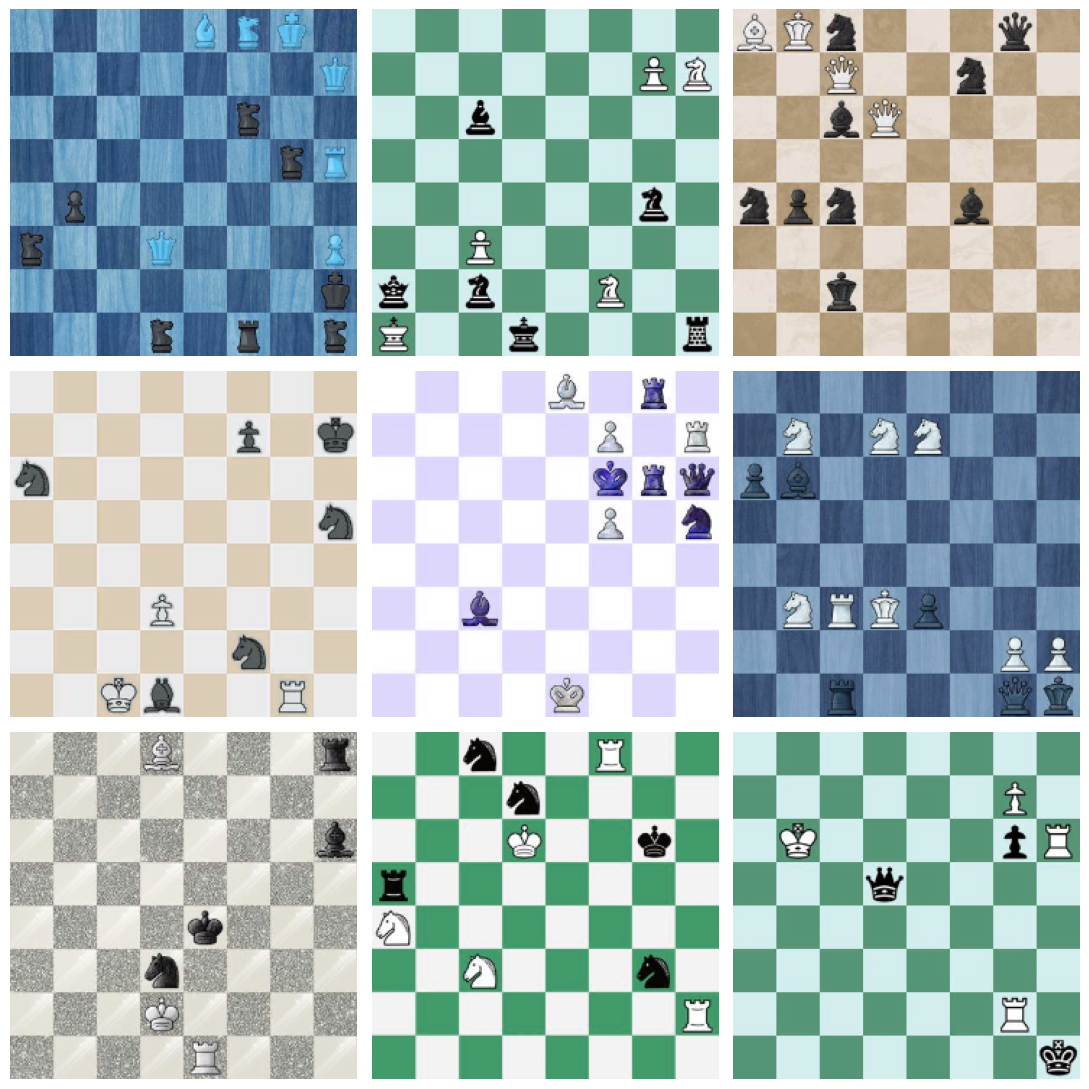

In [28]:
fig = plt.figure(figsize=(11, 11))
columns = 3
rows = 3
for i, img in zip(range(1, columns*rows +1), preprocessed_imgs):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

Feature engineering

In [29]:
def image_to_squares(img,heights,widths):
  squares = []
  for i in range(0,8):
    for j in range(0,8):
      squares.append(img[i*heights//8:i*heights//8+heights//8,j*widths//8:j*widths//8+widths//8])
  return np.array(squares)

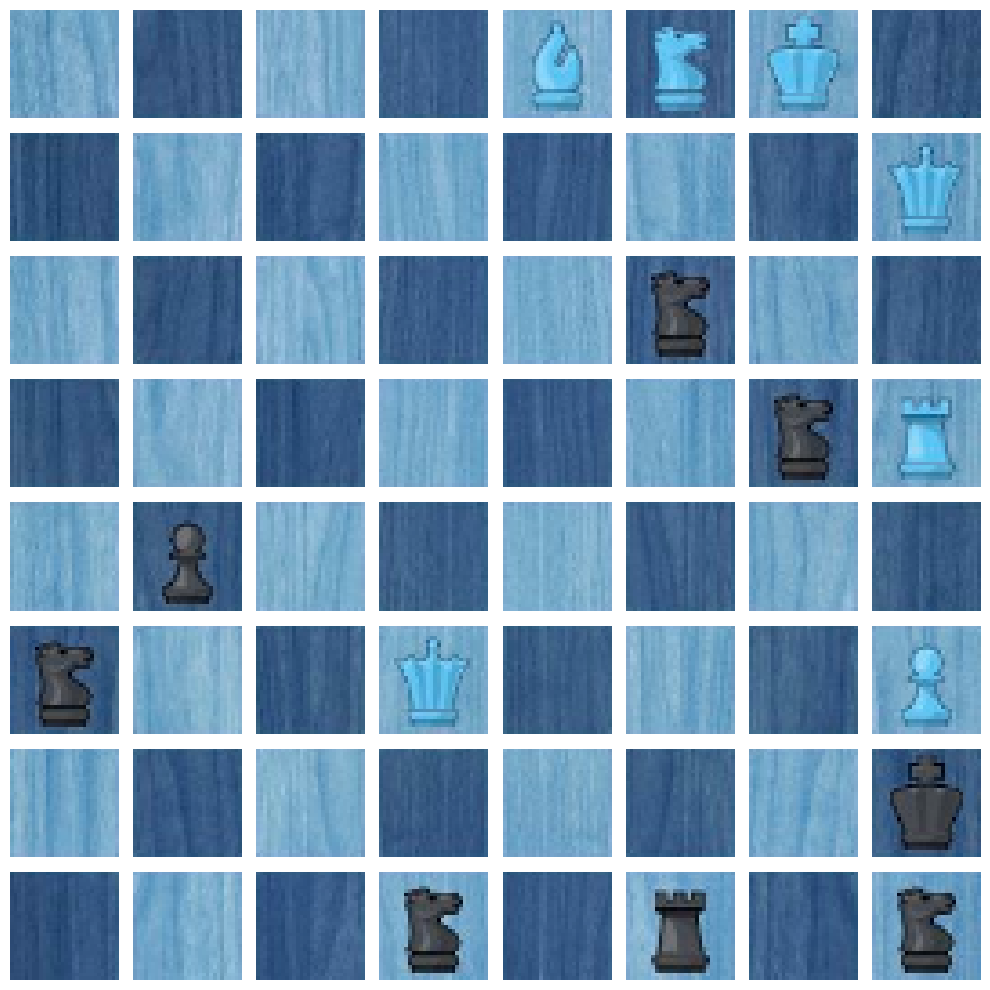

(64, 30, 30, 3)

In [30]:
sqaures= image_to_squares(preprocessed_imgs[0],240,240)
fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()
sqaures.shape

In [31]:
def preprocess_image(img_path):
    height =240
    width =240

    # change to Grey scal
    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)
  
    # resize the image to the desired size
    gray_image = cv2.resize(img, (width, height))
    
    # Normalize the image
    gray_image =(gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    squares = image_to_squares(gray_image,height,width)
    return squares

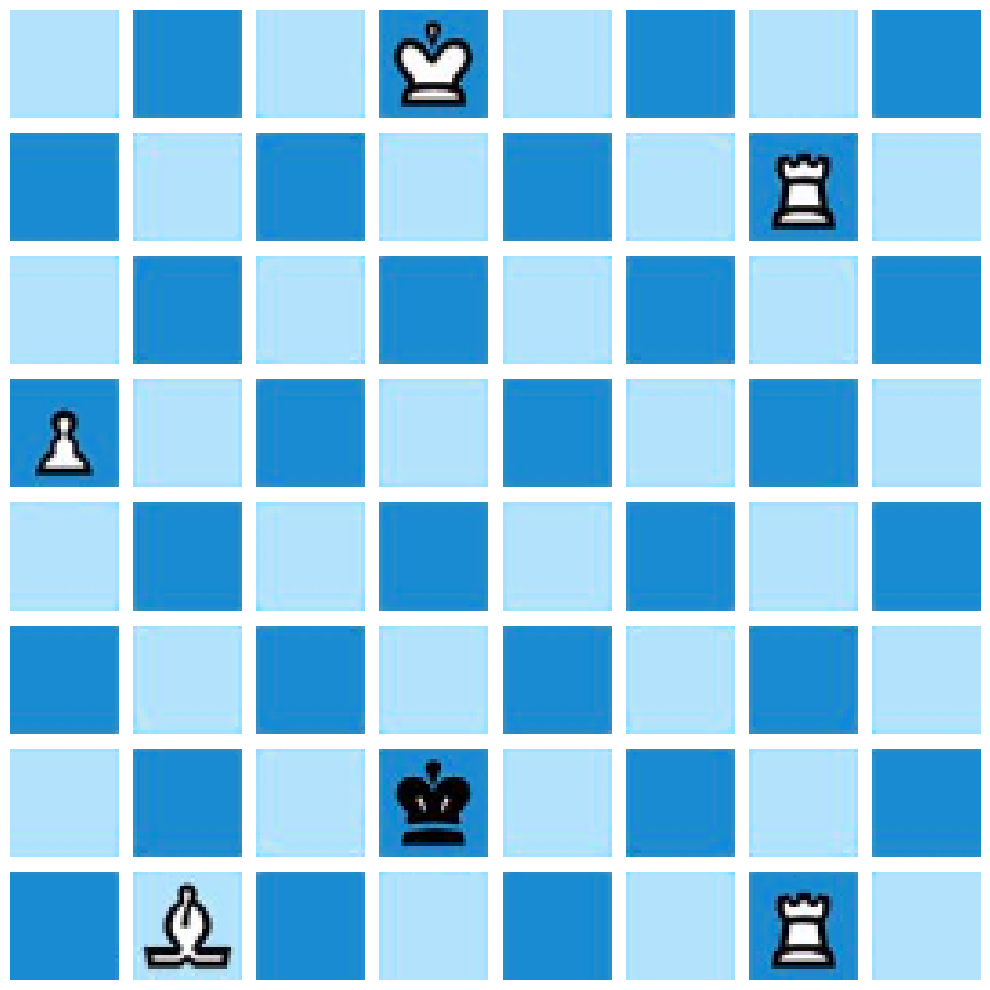

(64, 30, 30, 3)

In [32]:
sqaures=preprocess_image(train[444])

fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()
sqaures.shape

- Create a FEN Label Encode /Decoder Functions
- **NOTE** These 2 Functions are taken from this Kaggle notebook : https://www.kaggle.com/code/koryakinp/chess-fen-generator/notebook

In [33]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [34]:
def train_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y

def pred_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y

Model training

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# Add a convolutional layer
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.35))
model.add(Dense(13, activation='softmax'))
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 16)       │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         5,213 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,925 (73.93 KB)

 Trainable params: 18,925 (73.93 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Compile the model 
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [37]:
# Fit parameters
EPOCHS = 100

print("\nTraining Progress:\n------------------------")
hist = model.fit(
    train_gen(train), 
    steps_per_epoch=train_size // EPOCHS, 
    epochs=EPOCHS,
    validation_data=pred_gen(test), 
    validation_steps=test_size // EPOCHS
)



Training Progress:
------------------------
Epoch 1/100
 41/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5693 - loss: 1.6135

I0000 00:00:1720979150.483281     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7592 - loss: 1.0055 - val_accuracy: 0.8562 - val_loss: 0.4892
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8621 - loss: 0.4241 - val_accuracy: 0.8734 - val_loss: 0.3710
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8815 - loss: 0.3653 - val_accuracy: 0.9441 - val_loss: 0.2268
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9203 - loss: 0.2902 - val_accuracy: 0.9613 - val_loss: 0.1302
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9553 - loss: 0.1599 - val_accuracy: 0.9746 - val_loss: 0.1351
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9591 - loss: 0.1477 - val_accuracy: 0.9766 - val_loss: 0.0885
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9682 - loss: 0.1014 - val_accuracy: 0.9809 - val_loss: 0.0684
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9761 - loss: 0.0783 - val_accuracy: 0.9906

In [38]:
#- Save Model
model.save('../working/models/chess_position_detect_model.h5')

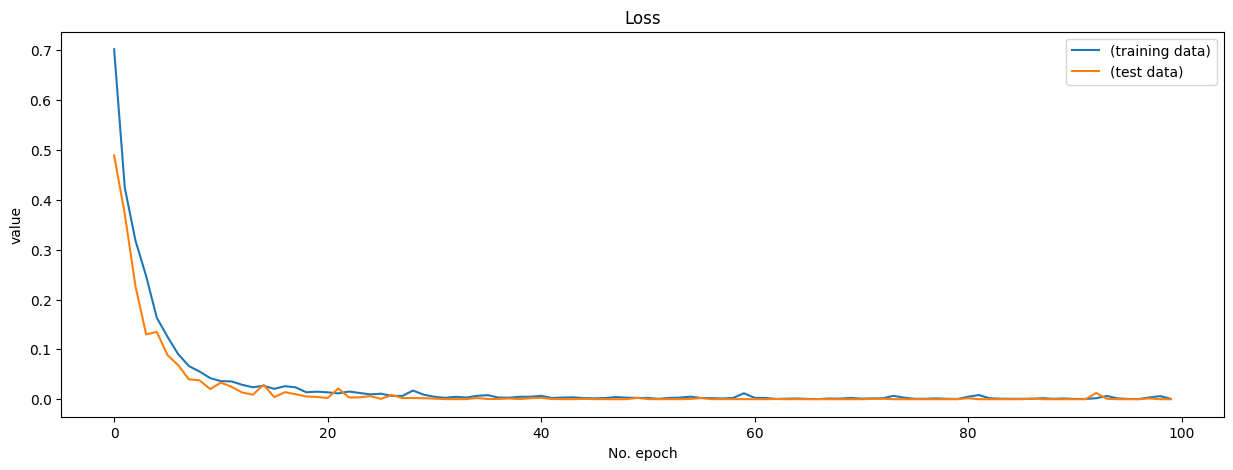

In [39]:
fig = plt.figure(figsize=(15, 5))
plt.plot(hist.history['loss'], label='(training data)')
plt.plot(hist.history['val_loss'], label='(test data)')

plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.title('Loss')
plt.show()

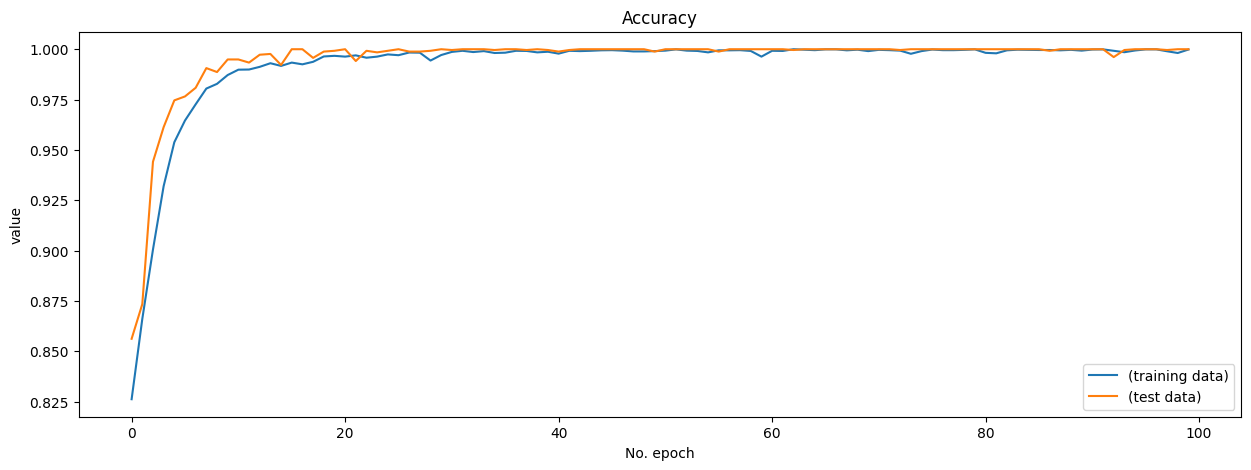

In [40]:
fig = plt.figure(figsize=(15, 5))
plt.plot(hist.history['accuracy'], label='(training data)')
plt.plot(hist.history['val_accuracy'], label='(test data)')

plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.title('Accuracy')
plt.show()

Generate predictions for the test set using the trained model.
Convert the predicted probabilities into class labels.
Reshape the flat array of class labels into 8x8 matrices, each of which could represent the predicted positions of pieces on a chessboard for a given test image.

In [44]:
res = (
  model.predict(pred_gen(test), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step


In [45]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([get_image_FEN_label(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.99925%


In [46]:
print("\nConfusion Matrix:\n------------------------")
confusion_matrix(test_fens, pred_fens)


Confusion Matrix:
------------------------


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [47]:
print("Precison:", precision_score(test_fens, pred_fens, average='weighted'))
print("Recall:", recall_score(test_fens, pred_fens, average='weighted'))
print("F1 Score:", f1_score(test_fens, pred_fens, average='weighted'))
print("Accuracy:", accuracy_score(test_fens, pred_fens))

Precison: 0.99925
Recall: 0.99925
F1 Score: 0.99925
Accuracy: 0.99925


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  


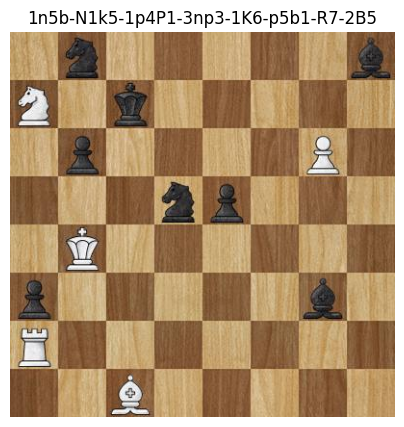

predicted FEN : 1n5b-N1k5-1p4P1-3np3-1K6-p5b1-R7-2B5


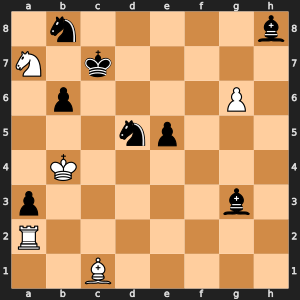

In [48]:
import matplotlib.image as mpimg
def display_with_predicted_fen(image):
    plt.figure(figsize=(5,5))
    pred = model.predict(preprocess_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()
    return fen

predicted_fen=display_with_predicted_fen(test[100])
print("predicted FEN :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
chess.svg.board(board, size=300)  


The objective of this project is to predict the chessboard configuration from an image and convert it into a FEN (Forsyth-Edwards Notation) string, which is a standard notation for describing a particular board position of a chess game. This process involves several steps:

- Preprocessing the Image: Convert the input image into a format suitable for the model to make predictions.
- Predicting the Chessboard Configuration: Use a trained convolutional neural network (CNN) to predict the configuration of pieces on the chessboard.
- Converting Predictions to FEN: Convert the model's predictions into a FEN string.
- Visualizing the Results: Display the original image with the predicted FEN notation and visualize the corresponding chessboard using the python-chess library.